In [1]:
#https://huggingface.co/blog/fine-tune-vit

import datasets 
import transformers

CODE_ROOT = '..'
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
from PIL import ImageFile
import random
ImageFile.LOAD_TRUNCATED_IMAGES = True
import argparse
import pickle
import sys
sys.path.append('%s/res/'%CODE_ROOT)
from models.models import get_model
from loader.loader import get_loader
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Skyler\Desktop\Deep Learning\final_project\generalization_to_OOD_category_viewpoint_combinations-main\demos
C:\Users\Skyler\Desktop\Deep Learning\final_project\generalization_to_OOD_category_viewpoint_combinations-main\demos\../res\loader\loader.py
C:\Users\Skyler\Desktop\Deep Learning\final_project\generalization_to_OOD_category_viewpoint_combinations-main\res\loader\category_to_class_number_per_car_synthetic_only_cars_no_police.p
{'Fordtest1957_clean': 0, 'Evo_clean': 1, 'Camaro_clean': 2, 'gto67_clean': 3, 'subaru_impreza_wrx_sti_08_clean': 4, 'fiat500blandswap_clean': 5, 'Shelby_clean': 6, 'GolfMK4-Cycles-Jay-Hardy-2011_clean': 7, 'Audi_R8_clean': 8, 'HUMMER_clean': 9, 'Honda_Civic_Type_R_clean': 20, 'Volvo_clean': 10, 'audia6_clean': 11, 'mini_clean': 12, 'porsche_911_clean': 13, 'CVPI2005_clean': 20, 'Porsche993_GT2_clean': 14, 'suzuki_sx4_clean': 15, 'rapide_clean': 16, 'cooper_mini_clean': 17, 'bg': 20}
{'car_i0066': 0, 'car_i0070': 1, 'car_i0072': 2, 'car_i0063': 3, '

In [2]:
#load Biased-Cars dataset and setup

DATASET_NAMES = ['rotation_model_15_compositions_seen']

NUM_EPOCHS = 20
BATCH_SIZE = 1
ARCH = 'LATE_BRANCHING_COMBINED'

image_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])


GPU = 1

In [3]:
NUM_CLASSES = (5,5,5,5)
loader_new = get_loader('multi_attribute_loader_file_list')

file_list_root = '%s/dataset_lists/biased_cars_lists/'%CODE_ROOT
att_path = "%s/data/biased_cars/att_dict_simplified.p"%CODE_ROOT

shuffles = {'train':True,'val':True,'test':False}

data_dir = '%s/data/'%CODE_ROOT

In [4]:
all_dsets = {}
all_dset_loaders = {}
all_dset_sizes = {}

for DATASET_NAME in DATASET_NAMES:
    file_lists = {}
    dsets = {}
    dset_loaders = {}
    dset_sizes = {}
    for phase in ['train','val','test']:
        file_lists[phase] = "%s/%s_list_%s.txt"%(file_list_root,phase,DATASET_NAME)
        dsets[phase] = loader_new(file_lists[phase],att_path, image_transform, data_dir)
        dset_loaders[phase] = torch.utils.data.DataLoader(dsets[phase], batch_size=BATCH_SIZE, shuffle = shuffles[phase], num_workers=2,drop_last=True)
        dset_sizes[phase] = len(dsets[phase])
    all_dsets[DATASET_NAME] = dsets
    all_dset_loaders[DATASET_NAME] = dset_loaders
    all_dset_sizes[DATASET_NAME] = dset_sizes

In [5]:
#https://danielvanstrien.xyz/metadata/deployment/huggingface/ethics/huggingface-datasets/faiss/2022/01/13/image_search.html
#create the dataframes for the ViT

from torchvision.transforms import ToPILImage
from PIL import Image
import pandas as pd
import io
from collections import defaultdict

train_data = defaultdict(list)

selection = 3 #vehicle=3, rotation=1

for data in tqdm(dset_loaders['train']):
    inputs, labels_all, paths = data
    #print(labels_all)
    #example output: tensor([[0, 9, 0, 8]])
    #interpret as: digit=8, rotation=9
    train_data['image_file_path'].append(str(paths[0]))
    train_data['image'].append(os.path.basename(str(paths[0])))
    train_data['labels'].append(labels_all.data.numpy()[0][selection])
    
val_data = defaultdict(list)

for data in tqdm(dset_loaders['val']):
    inputs, labels_all, paths = data
    
    val_data['image_file_path'].append(str(paths[0]))
    val_data['image'].append(os.path.basename(str(paths[0])))
    val_data['labels'].append(labels_all.data.numpy()[0][selection])
    
test_data = defaultdict(list)

for data in tqdm(dset_loaders['test']):
    inputs, labels_all, paths = data
    
    test_data['image_file_path'].append(str(paths[0]))
    test_data['image'].append(os.path.basename(str(paths[0])))
    test_data['labels'].append(str(labels_all.data.numpy()[0][selection]))

  0%|          | 0/3400 [00:00<?, ?it/s]

  0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

In [6]:
#create dataset objects, and make class labels

from datasets import Dataset
from datasets import ClassLabel
train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)
test_dataset = Dataset.from_dict(test_data)

train_dataset.features['labels'] = ClassLabel(num_classes=5, names=['0','1','2','3','4'], id=None)
train_dataset.features['labels']

ClassLabel(num_classes=5, names=['0', '1', '2', '3', '4'], id=None)

In [7]:
#function to load and reformat image

from resizeimage import resizeimage
from io import BytesIO
def load_image(path):
    
    img = Image.open(path)
    img = img.convert("RGB")
    b = BytesIO()
    img.save(b,format="jpeg")
    im = Image.open(b)
        
    return im 

In [8]:
#function to load image

def try_load_image(filename):
    try:
        image = load_image(filename)
        if isinstance(image, Image.Image):
            return image
    except Image.UnidentifiedImageError:
        return None

In [9]:
#load the images from supplied paths
#https://huggingface.co/docs/transformers/training

train_dataset = train_dataset.map(lambda example: {"img": try_load_image(example['image_file_path'])},writer_batch_size=50)
val_dataset = val_dataset.map(lambda example: {"img": try_load_image(example['image_file_path'])},writer_batch_size=50)
test_dataset = test_dataset.map(lambda example: {"img": try_load_image(example['image_file_path'])},writer_batch_size=50)


  0%|          | 0/3400 [00:00<?, ?ex/s]

  0%|          | 0/445 [00:00<?, ?ex/s]

  0%|          | 0/800 [00:00<?, ?ex/s]

In [10]:
#select 600 images for training, 200 for validation, and 200 for testing

#train_dataset = train_dataset.select(range(600))
#val_dataset = val_dataset.select(range(200))
#test_dataset = test_dataset.select(range(200))

In [11]:
ex = train_dataset[400]
ex

{'image_file_path': '../data//biased_cars/BLACK_CARS/train/images/frame_0005_0_5_8860680_2020-01-12_AWHQFQYR.png',
 'image': 'frame_0005_0_5_8860680_2020-01-12_AWHQFQYR.png',
 'labels': 1,
 'img': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x26787CF7B80>}

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x26787CF7B80>


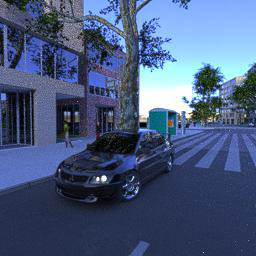

In [12]:
image = ex['img']
print(image)
image

In [13]:
labels = train_dataset.features['labels']
labels

ClassLabel(num_classes=5, names=['0', '1', '2', '3', '4'], id=None)

In [14]:
labels.int2str(ex['labels'])


'1'

In [15]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
print(feature_extractor)

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}



In [16]:
print(image)
feature_extractor(image, return_tensors='pt')


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x26787CF7B80>


{'pixel_values': tensor([[[[-0.0196, -0.1451, -0.2863,  ...,  0.0275,  0.0275,  0.0275],
          [-0.2235, -0.1216, -0.1686,  ...,  0.0275,  0.0275,  0.0275],
          [-0.2392, -0.1843, -0.1686,  ...,  0.0353,  0.0353,  0.0353],
          ...,
          [-0.7020, -0.7098, -0.7176,  ..., -0.7020, -0.7020, -0.6941],
          [-0.6941, -0.7020, -0.7098,  ..., -0.7020, -0.7020, -0.6863],
          [-0.6784, -0.6941, -0.7020,  ..., -0.6941, -0.6863, -0.6706]],

         [[-0.0196, -0.1373, -0.2784,  ...,  0.3569,  0.3569,  0.3569],
          [-0.2157, -0.1137, -0.1608,  ...,  0.3569,  0.3569,  0.3569],
          [-0.2314, -0.1765, -0.1608,  ...,  0.3725,  0.3725,  0.3725],
          ...,
          [-0.6314, -0.6392, -0.6471,  ..., -0.6235, -0.6235, -0.6157],
          [-0.6235, -0.6314, -0.6392,  ..., -0.6235, -0.6235, -0.6078],
          [-0.6078, -0.6235, -0.6314,  ..., -0.6157, -0.6078, -0.5922]],

         [[ 0.1686,  0.0196, -0.1529,  ...,  1.0000,  1.0000,  1.0000],
          [-0

In [17]:
def process_example(example):
    inputs = feature_extractor(example['img'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [18]:
process_example(train_dataset[0])


{'pixel_values': tensor([[[[ 0.4510, -0.2235, -0.7176,  ...,  0.1216,  0.1216,  0.1216],
          [-0.4667, -0.7255, -0.8824,  ...,  0.1294,  0.1216,  0.1216],
          [-0.8353, -0.8275, -0.8118,  ...,  0.1294,  0.1294,  0.1294],
          ...,
          [-0.6627, -0.6078, -0.6078,  ..., -0.8196, -0.8196, -0.8196],
          [-0.8745, -0.6706, -0.6392,  ..., -0.8196, -0.8196, -0.8196],
          [-0.9843, -0.8980, -0.6863,  ..., -0.8196, -0.8196, -0.8196]],

         [[ 0.5765, -0.0980, -0.5922,  ...,  0.4353,  0.4353,  0.4353],
          [-0.3412, -0.6000, -0.7569,  ...,  0.4431,  0.4353,  0.4353],
          [-0.7098, -0.7020, -0.7020,  ...,  0.4431,  0.4431,  0.4431],
          ...,
          [-0.5137, -0.4510, -0.4745,  ..., -0.7490, -0.7490, -0.7490],
          [-0.7020, -0.5059, -0.4980,  ..., -0.7490, -0.7490, -0.7490],
          [-0.8980, -0.8196, -0.5294,  ..., -0.7490, -0.7490, -0.7490]],

         [[ 0.7647,  0.1686, -0.3255,  ...,  1.0000,  1.0000,  1.0000],
          [-0

In [19]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['img']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

In [20]:
prepared_ds_train = train_dataset.with_transform(transform)
prepared_ds_val = val_dataset.with_transform(transform)
prepared_ds_test = test_dataset.with_transform(transform)


In [21]:
prepared_ds_train[0:2]


{'pixel_values': tensor([[[[ 0.4510, -0.2235, -0.7176,  ...,  0.1216,  0.1216,  0.1216],
          [-0.4667, -0.7255, -0.8824,  ...,  0.1294,  0.1216,  0.1216],
          [-0.8353, -0.8275, -0.8118,  ...,  0.1294,  0.1294,  0.1294],
          ...,
          [-0.6627, -0.6078, -0.6078,  ..., -0.8196, -0.8196, -0.8196],
          [-0.8745, -0.6706, -0.6392,  ..., -0.8196, -0.8196, -0.8196],
          [-0.9843, -0.8980, -0.6863,  ..., -0.8196, -0.8196, -0.8196]],

         [[ 0.5765, -0.0980, -0.5922,  ...,  0.4353,  0.4353,  0.4353],
          [-0.3412, -0.6000, -0.7569,  ...,  0.4431,  0.4353,  0.4353],
          [-0.7098, -0.7020, -0.7020,  ...,  0.4431,  0.4431,  0.4431],
          ...,
          [-0.5137, -0.4510, -0.4745,  ..., -0.7490, -0.7490, -0.7490],
          [-0.7020, -0.5059, -0.4980,  ..., -0.7490, -0.7490, -0.7490],
          [-0.8980, -0.8196, -0.5294,  ..., -0.7490, -0.7490, -0.7490]],

         [[ 0.7647,  0.1686, -0.3255,  ...,  1.0000,  1.0000,  1.0000],
          [-0

In [22]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [23]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [24]:
from transformers import ViTForImageClassification

#labels = prepared_ds_train.features['labels'].names
labels = train_dataset.features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [26]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds_train,
    eval_dataset=prepared_ds_val,
    tokenizer=feature_extractor,
)
torch.cuda.empty_cache()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

Using amp half precision backend


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_fea

In [27]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

C:\Users\Skyler\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3400
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 852


Step,Training Loss,Validation Loss,Accuracy
100,0.512700,0.485738,0.862921
200,0.336400,0.244540,0.930337
300,0.198600,0.221625,0.930337
400,0.090400,0.135530,0.961798
500,0.032900,0.204462,0.948315
600,0.074900,0.153526,0.957303
700,0.009400,0.120841,0.970787
800,0.010500,0.128197,0.970787


***** Running Evaluation *****
  Num examples = 445
  Batch size = 8
Saving model checkpoint to ./vit-base-beans\checkpoint-100
Configuration saved in ./vit-base-beans\checkpoint-100\config.json
Model weights saved in ./vit-base-beans\checkpoint-100\pytorch_model.bin
Feature extractor saved in ./vit-base-beans\checkpoint-100\preprocessor_config.json
Deleting older checkpoint [vit-base-beans\checkpoint-700] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 445
  Batch size = 8
Saving model checkpoint to ./vit-base-beans\checkpoint-200
Configuration saved in ./vit-base-beans\checkpoint-200\config.json
Model weights saved in ./vit-base-beans\checkpoint-200\pytorch_model.bin
Feature extractor saved in ./vit-base-beans\checkpoint-200\preprocessor_config.json
Deleting older checkpoint [vit-base-beans\checkpoint-800] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 445
  Batch size = 8
Saving model checkpoint to ./vit-base-beans\checkpoin

***** train metrics *****
  epoch                    =         4.0
  total_flos               = 981538925GF
  train_loss               =      0.2429
  train_runtime            =  0:05:14.64
  train_samples_per_second =      43.224
  train_steps_per_second   =       2.708


In [28]:
metrics = trainer.evaluate(prepared_ds_val)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 445
  Batch size = 8


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9708
  eval_loss               =     0.1208
  eval_runtime            = 0:00:03.88
  eval_samples_per_second =    114.461
  eval_steps_per_second   =     14.404
